# Gaussian (RBF kernel) SVM Model

In [1]:
import pandas as pd
import numpy as np
from scipy.special import logit
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score, confusion_matrix, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn import tree
from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
test_size = 0.2
seed = 0

In [3]:
# Load, transform and scale data
train_file_path = 'project_train.csv'

data_train = pd.read_csv(train_file_path)

features_needed = ['speechiness', 'liveness', 'energy', 'loudness', 'valence']

training_set = data_train[features_needed + ['Label']]

rows_to_remove = [68, 84, 94]  # 68: speechiness outlier, 84: energy false data, 94: loudness false data

training_set = training_set.drop(rows_to_remove)
training_set = training_set.reset_index(drop=True)

vars_to_transform = [
    "energy",
    "speechiness",
    "liveness",
    "valence",
]

training_set_transformed = training_set.copy()
training_set_transformed[vars_to_transform] = training_set_transformed[vars_to_transform].transform(logit)
training_set_transformed[vars_to_transform + ['loudness']] = preprocessing.scale(training_set_transformed[vars_to_transform + ['loudness']])

# Split to test and train set, train model and predict
predictors_train_svm, predictors_test_svm, response_train_svm, response_test_svm = train_test_split(training_set_transformed[features_needed], training_set_transformed['Label'], test_size=test_size, random_state=seed)

model = SVC(kernel='rbf', random_state=0, C=1, gamma=1)
model.fit(predictors_train_svm, response_train_svm)

response_svm = model.predict(predictors_test_svm)

accuracy_svm = accuracy_score(response_test_svm, response_svm)
precision_svm = precision_score(response_test_svm, response_svm)
recall_svm = recall_score(response_test_svm, response_svm)
kappa_svm = cohen_kappa_score(response_test_svm, response_svm)

# Compute confusion matrix
cm_SVM = confusion_matrix(response_test_svm, response_svm)

# Regression model

In [4]:
selected_variables = [
    "energy acousticness",
    "loudness speechiness",
    "energy instrumentalness",
    "loudness valence",
    "danceability",
    "energy liveness",
    "speechiness",
    "speechiness tempo",
    "energy loudness",
    "danceability^2",
    "key_6",
    "mode_1",
    "tempo",
    "instrumentalness liveness",
    "key_10",
    "valence^2",
    "energy speechiness",
    "danceability tempo",
    "danceability instrumentalness",
    "loudness instrumentalness",
    "instrumentalness tempo",
    "instrumentalness",
    "energy tempo",
    "key_8",
    "speechiness^2",
    "energy",
    "acousticness",
    "acousticness^2",
    "key_4",
    "speechiness liveness",
]

best_C = 2.0

In [5]:
def generate_train_test_split(df, vars_to_drop=[]):
    """
    This function generates a (seeded) 80/20 train test split for the spotify data with the categorical "key" and "mode" are
    transformed to dummy variables, with no interaction terms included.

    Params:
    -------
    df : pandas.DataFrame
        The columns should include each of the columns of the original data frame of song data.
    vars_to_drop : list
        A list of labels containing variables not to be included in the model.

    Returns:
    --------
    (pandas.DataFrame, pandas.DataFrame, pandas.Series, pandas.Series):
        A sequence of four data frames/series with the first two being the training and testing predictors
        and the last two being the labels of the training data and testing data.
    """

    all_predictors = df.drop(vars_to_drop + ["Label"], axis=1)
    response = df["Label"]

    # We drop_first because one of the variables in each of key,
    # mode is determined by the values of the others
    # (for example mode != 0 implies mode = 1)
    encoded_data = pd.get_dummies(
        all_predictors, columns=["key", "mode"], drop_first=True
    )
    return train_test_split(
        encoded_data, response, test_size=test_size, random_state=seed
    )


## Data import and processing
#############################

train_file_path = "project_train.csv"
data_train = pd.read_csv(train_file_path)
rows_to_remove = [68, 84, 94]  # 84: energy false data, 94: loudness false data

data = data_train.drop(rows_to_remove)
data = data.reset_index(drop=True)

vars_to_transform = [
    "danceability",
    "energy",
    "speechiness",
    "acousticness",
    "liveness",
    "valence",
]

transformed_data = data.copy()
transformed_data[vars_to_transform] = transformed_data[vars_to_transform].transform(
    logit
)

scaled_data = transformed_data.copy()
scaled_data[vars_to_transform + ["loudness", "tempo"]] = preprocessing.scale(
    scaled_data[vars_to_transform + ["loudness", "tempo"]]
)

continuous_variables = [
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
]
categorical_variables = ["key", "mode"]

# We fit a model including all the variables in the previous models, all products of continuous variables (including squared variables) and an intercept.
poly = preprocessing.PolynomialFeatures(2)
continuous_interactions = pd.DataFrame(
    poly.fit_transform(scaled_data[continuous_variables]),
    columns=poly.get_feature_names_out(),
)

interaction_data = continuous_interactions.combine_first(scaled_data)
interaction_data = interaction_data.reindex(
    continuous_interactions.columns.to_list() + categorical_variables + ["Label"],
    axis=1,
)

# Scaling
scaled_interaction_data = interaction_data.copy()
scaled_interaction_data[interaction_data.columns[:-3]] = preprocessing.scale(
    scaled_interaction_data[interaction_data.columns[:-3]]
)

predictors_train_regr, predictors_test_regr, response_train_regr, response_test_regr = (
    generate_train_test_split(scaled_interaction_data)
)

# Sequentially Selected Model
predictors_train_regr, predictors_test_regr = (
    p[selected_variables] for p in (predictors_train_regr, predictors_test_regr)
)
scaled_interaction_model = LogisticRegression(C=best_C)
scaled_interaction_model.fit(predictors_train_regr, response_train_regr)
response_regr = scaled_interaction_model.predict(predictors_test_regr)

accuracy_regr = accuracy_score(response_test_regr, response_regr)
precision_regr = precision_score(response_test_regr, response_regr)
recall_regr = recall_score(response_test_regr, response_regr)
kappa_regr = cohen_kappa_score(response_test_regr, response_regr)

# Compute confusion matrix
cm_Regr = confusion_matrix(response_test_regr, response_regr)

# Random forest

In [6]:
train_df = pd.read_csv("project_train.csv")

rows_to_remove = [68, 84, 94]  # 68: speechiness outlier, 84: energy false data, 94: loudness false data

train_df = train_df.drop(rows_to_remove)
train_df = train_df.reset_index(drop=True)

# Transformation and scaling
vars_to_transform = ["danceability","energy","speechiness","acousticness","liveness","valence"]

train_df[vars_to_transform] = train_df[vars_to_transform].transform(logit)
train_df[vars_to_transform + ['loudness','tempo']] = preprocessing.scale(train_df[vars_to_transform + ['loudness','tempo']])

predictors_train_tree, predictors_test_tree, response_train_tree, response_test_tree = train_test_split(train_df.drop(columns=['Label']), 
                                                                                                        train_df['Label'], 
                                                                                                        test_size=test_size, 
                                                                                                        random_state=seed)
# Create the Random Forest model
model_rf = RandomForestClassifier(max_depth= None, min_samples_leaf= 3, n_estimators= 75, random_state=0)
model_rf.fit(predictors_train_tree, response_train_tree)                   # Fit the model
   
# Predict on the test data
response_rf = model_rf.predict(predictors_test_tree)

accuracy_rf = accuracy_score(response_test_tree, response_rf)
precision_rf = precision_score(response_test_tree, response_rf)
recall_rf = recall_score(response_test_tree, response_rf)
kappa_rf = cohen_kappa_score(response_test_tree, response_rf)

cm_rf = confusion_matrix(response_test_tree, response_rf)

# Gradient boosting

In [7]:
clf_gbm = GradientBoostingClassifier(learning_rate = 0.1, max_depth=3, n_estimators = 125, random_state=seed)
clf_gbm = clf_gbm.fit(predictors_train_tree, response_train_tree)
response_gbm = clf_gbm.predict(predictors_test_tree)

accuracy_gbm = accuracy_score(response_test_tree, response_gbm)
precision_gbm = precision_score(response_test_tree, response_gbm)
recall_gbm = recall_score(response_test_tree, response_gbm)
kappa_gbm = cohen_kappa_score(response_test_tree, response_gbm)

cm_gbm = confusion_matrix(response_test_tree, response_gbm)

# Comparison

## Confusion Matrix

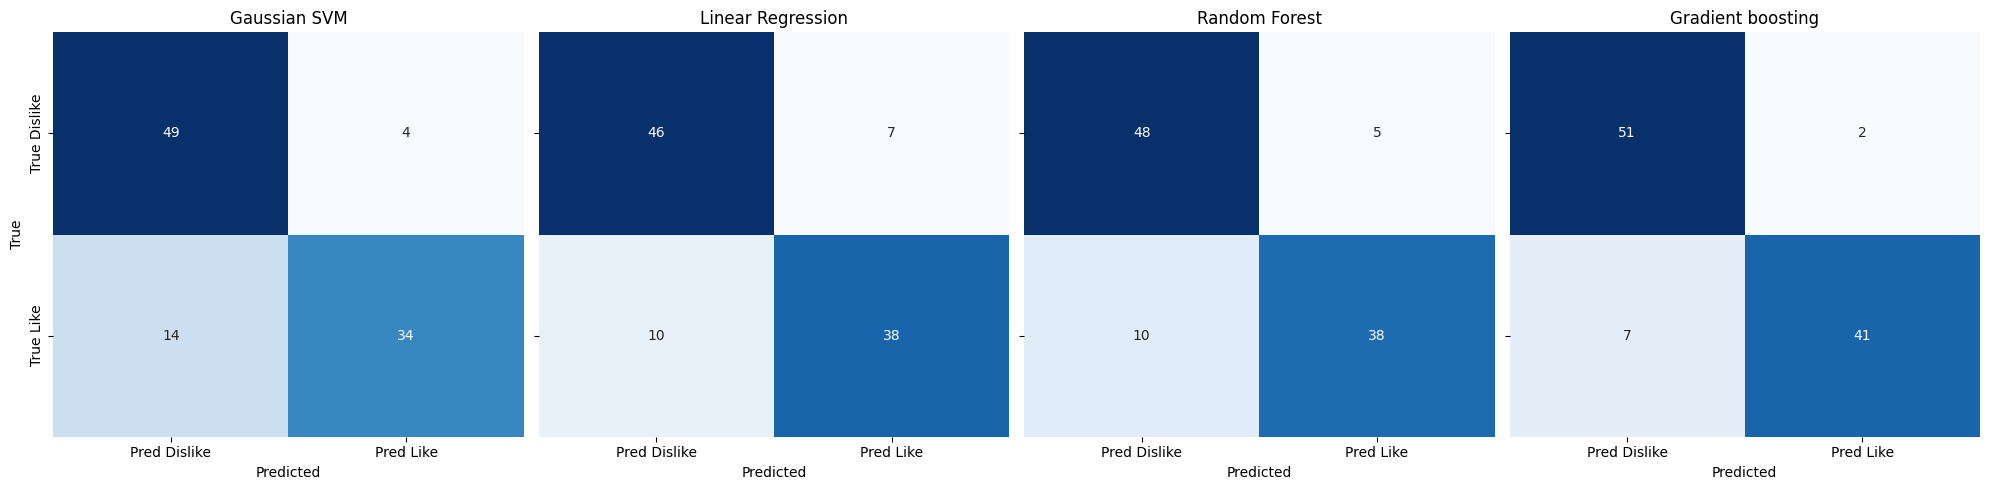

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

sns.heatmap(cm_SVM, annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=['Pred Dislike', 'Pred Like'], yticklabels=['True Dislike', 'True Like'], cbar=False)
axes[0].set_title('Gaussian SVM')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(cm_Regr, annot=True, fmt='d', cmap='Blues', ax=axes[1], xticklabels=['Pred Dislike', 'Pred Like'], yticklabels=['True Dislike', 'True Like'], cbar=False)
axes[1].set_title('Linear Regression')
axes[1].set_xlabel('Predicted')

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[2], xticklabels=['Pred Dislike', 'Pred Like'], yticklabels=['True Dislike', 'True Like'], cbar=False)
axes[2].set_title('Random Forest')
axes[2].set_xlabel('Predicted')

sns.heatmap(cm_gbm, annot=True, fmt='d', cmap='Blues', ax=axes[3], xticklabels=['Pred Dislike', 'Pred Like'], yticklabels=['True Dislike', 'True Like'], cbar=False)
axes[3].set_title('Gradient boosting')
axes[3].set_xlabel('Predicted')

# Adjust layout
plt.tight_layout()
plt.savefig('ConfusionMatrix_comparison.eps', format='eps')
plt.show()

## Performance Metrics

In [9]:
metrics_table = {
    "Model": ["Gaussian SVM", "Linear Regression", "Random Forest", "Gradient Boosting"],
    "Accuracy (\\%)": [accuracy_svm*100, accuracy_regr*100, accuracy_rf*100, accuracy_gbm*100],
    "Precision (\\%)": [precision_svm*100, precision_regr*100, precision_rf*100, precision_gbm*100],
    "Recall (\\%)": [recall_svm*100, recall_regr*100, recall_rf*100, recall_gbm*100],
    "Kappa": [kappa_svm, kappa_regr, kappa_rf, kappa_gbm]
}

# Output to latex
df_metrics = pd.DataFrame(metrics_table)
print(df_metrics)

               Model  Accuracy (\%)  Precision (\%)  Recall (\%)     Kappa
0       Gaussian SVM      82.178218       89.473684    70.833333  0.639143
1  Linear Regression      83.168317       84.444444    79.166667  0.661541
2      Random Forest      85.148515       88.372093    79.166667  0.700770
3  Gradient Boosting      91.089109       95.348837    85.416667  0.820462


In [10]:
# Table for report
latex_table = df_metrics.to_latex(index=False, float_format="%.2f", caption="Summary of Classifier Performance", label="tab:performance_metrics", position='h')
latex_table = latex_table.replace('\\begin{table}[h]', '\\begin{table}[h]\n\\centering')
print(latex_table)

\begin{table}[h]
\centering
\caption{Summary of Classifier Performance}
\label{tab:performance_metrics}
\begin{tabular}{lrrrr}
\toprule
Model & Accuracy (\%) & Precision (\%) & Recall (\%) & Kappa \\
\midrule
Gaussian SVM & 82.18 & 89.47 & 70.83 & 0.64 \\
Linear Regression & 83.17 & 84.44 & 79.17 & 0.66 \\
Random Forest & 85.15 & 88.37 & 79.17 & 0.70 \\
Gradient Boosting & 91.09 & 95.35 & 85.42 & 0.82 \\
\bottomrule
\end{tabular}
\end{table}



## Cross-Validation Results:

In [11]:
def encode_data(df, vars_to_drop=[]):

    all_predictors = df.drop(vars_to_drop + ["Label"], axis=1)
    response = df["Label"]

    # We drop_first because one of the variables in each of key,
    # mode is determined by the values of the others
    # (for example mode != 0 implies mode = 1)
    encoded_data = pd.get_dummies(
        all_predictors, columns=["key", "mode"], drop_first=True, dtype=float
    )

    return encoded_data, response

In [12]:
# SVM
data_train = pd.read_csv(train_file_path)

features_needed = ["speechiness", "liveness", "energy", "loudness", "valence"]

training_set = data_train[features_needed + ["Label"]]

rows_to_remove = [
    68,
    84,
    94,
]  # 68: speechiness outlier, 84: energy false data, 94: loudness false data

training_set = training_set.drop(rows_to_remove)
training_set = training_set.reset_index(drop=True)

vars_to_transform = [
    "energy",
    "speechiness",
    "liveness",
    "valence",
]

training_set_transformed = training_set.copy()
training_set_transformed[vars_to_transform] = training_set_transformed[
    vars_to_transform
].transform(logit)
training_set_transformed[vars_to_transform + ["loudness"]] = preprocessing.scale(
    training_set_transformed[vars_to_transform + ["loudness"]]
)

# Split to test and train set, train model and predict
predictors_full_SVM, response_full_SVM = (
    training_set_transformed[features_needed],
    training_set_transformed["Label"],
)

model_SVM = SVC(kernel="rbf", random_state=0, C=1, gamma=1)


# REGRESSION:
# model.fit(predictors_train, response_train)
predictors_full_regression, response_full_regression = encode_data(
    scaled_interaction_data
)


predictors_full_regression = predictors_full_regression[selected_variables]
model_reg = LogisticRegression(C=best_C)


# RANDOM FOREST
# Change values in mislabeled rows
train_df = data_train.copy()
rows_to_remove = [
    68,
    84,
    94,
]  # 68: speechiness outlier, 84: energy false data, 94: loudness false data

train_df = train_df.drop(rows_to_remove)
train_df = train_df.reset_index(drop=True)

# Transformation and scaling
vars_to_transform = [
    "danceability",
    "energy",
    "speechiness",
    "acousticness",
    "liveness",
    "valence",
]

train_df[vars_to_transform] = train_df[vars_to_transform].transform(logit)
train_df[vars_to_transform + ["loudness", "tempo"]] = preprocessing.scale(
    train_df[vars_to_transform + ["loudness", "tempo"]]
)

predictors_full_rf, response_full_rf = (
        train_df.drop(columns=["Label"]),
        train_df["Label"]
)

#RANDOM FOREST
model_rf = RandomForestClassifier(
    max_depth=None, min_samples_leaf=3, n_estimators=75, random_state=0
)

# GRADIENT BOOSTING
clf_gbm = GradientBoostingClassifier(
    learning_rate=0.1, max_depth=3, n_estimators=125, random_state=seed
)

In [13]:
metrics = ["accuracy", "recall", "precision", "kappa"]
score_dict_template = {"accuracy": [], "recall": [], "precision": [], "kappa": []}
metrics_dict = {
    "SVM": score_dict_template.copy(),
    "Logistic Regression": score_dict_template.copy(),
    "Random Forest": score_dict_template.copy(),
    "Gradient Boosting": score_dict_template.copy(),
}

In [14]:
cv = KFold(shuffle=True, random_state=0)
kappa_scorer = make_scorer(cohen_kappa_score)
for metric in metrics:
    scorer = None
    if metric == "kappa":
        scorer = kappa_scorer
    else:
        scorer = metric
    metrics_dict["SVM"][metric] = cross_val_score(
        model_SVM, predictors_full_SVM, response_full_SVM, scoring=scorer, cv=cv
    )
    metrics_dict["Logistic Regression"][metric] = cross_val_score(
        model_reg,
        predictors_full_regression,
        response_full_regression,
        scoring=scorer,
        cv=cv,
    )
    metrics_dict["Random Forest"][metric] = cross_val_score(
        model_rf,
        predictors_full_rf,
        response_full_rf,
        scoring=scorer,
        cv=cv,
    )
    metrics_dict["Gradient Boosting"][metric] = cross_val_score(
        clf_gbm,
        predictors_full_rf,
        response_full_rf,
        scoring=scorer,
        cv=cv,
    )

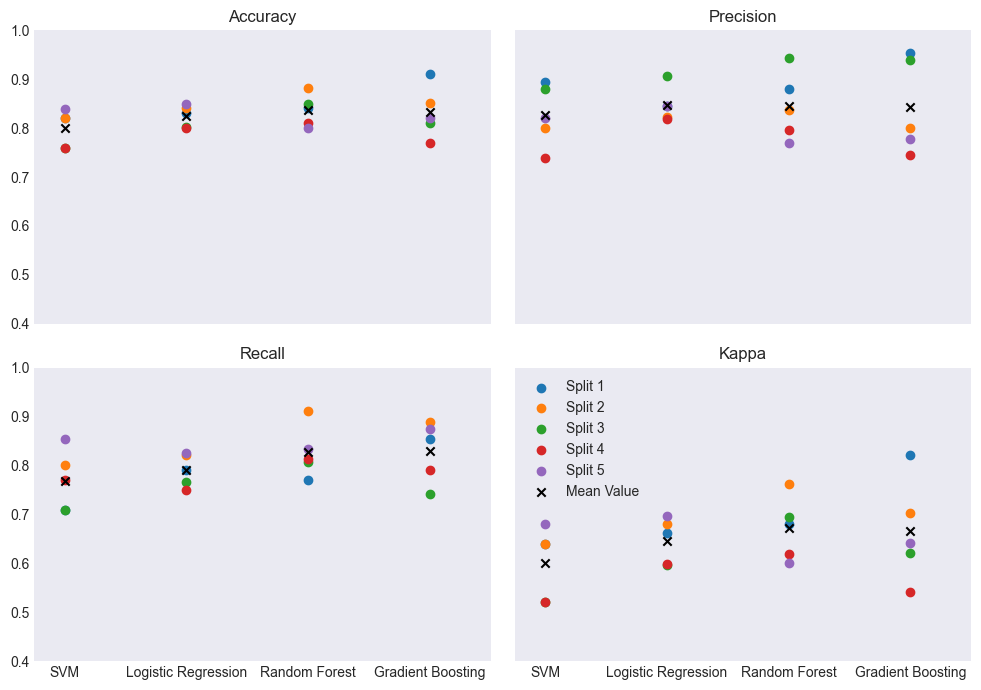

In [15]:
plt.style.use("seaborn-v0_8-dark")
n_models = len(metrics_dict.keys())
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
for i, metric in enumerate(metrics):

    coords = (i % 2, i // 2)
    for j in range(5):
        x = []
        y = []
        ax[coords].scatter(
            range(n_models),
            [metrics_dict[c][metric][j] for c in metrics_dict.keys()],
            label="Split " + str(j + 1),
        )
    ax[coords].scatter(
        range(n_models),
        [np.mean(metrics_dict[c][metric]) for c in metrics_dict.keys()],
        marker="x",
        color="black",
        label="Mean Value",
    )
    ax[coords].set_ylim(0.4, 1.0)
    ax[coords].set_xlim(-0.25, 3.5)

    # l.set_title("Cross Validation Split")
    # Customize x-axis
    ax[coords].set_xticks([])

    # ax.set_xlabel("Categories")
    # ax[coords].set_ylabel("Accuracy")
    ax[coords].set_title(metric.capitalize())
    # ax.title("Scatter Plot of Points by Category")
l = ax[1, 1].legend()
ax[0, 1].set_yticks([])
ax[1, 1].set_yticks([])
ax[1, 0].set_xticks(range(len(metrics_dict.keys())), metrics_dict.keys())
ax[1, 1].set_xticks(range(len(metrics_dict.keys())), metrics_dict.keys())

fig.tight_layout()
plt.savefig("accuracy-different-splits.pdf", dpi=1000)
plt.show()